# spectrafit.py example

This module constains a set of functions designed to fit a model consisting of a sum of pseudo-Voigt profiles to already baseline subtracted Raman spectroscopy data. These functions are primarily accessed in an automated fashion via the dataprep.py module.

This module contains the following functions:
1. spectrafit.peak_detect( )
2. spectrafit.set_parmas( )
3. spectrafit.model_fit( )
4. spectrafit.plot_fit( )
5. spectrafit.export_fit_data( )
6. spectrafit.fit_data( )
7. spectrafit.build_custom_model( )
8. spectrafit.apply_old_model( )
9. spectrafit.superimpose_next( )
10. spectrafit.superimpose_set( )

Developed by the Raman-Noodles team (2019 DIRECT Cohort, University of Washington)

In [9]:
# imports
import h5py
import numpy as np
from shutil import copyfile
from ramandecompy import spectrafit

We will open an example hdf5 file that contains formic acid mixture spectra at 300C and various residence times

In [11]:
hdf5 = h5py.File('../ramandecompy/tests/test_files/test_experiment.hdf5', 'r')
x_data = np.asarray(hdf5['300C/25s/wavenumber'])
y_data = np.asarray(hdf5['300C/25s/counts'])
hdf5.close()

### spectrafit.peak_detect
    A function that utilizes scipy to identify local maxima from input spectral data. Default
    detection criteria are based upon normalized values for the y axis (counts) spectra data;
    however, the option remains to adjust the parameters to achieve the best fit, if the user
    so chooses.
    
    These detected peaks are used next to begin to define a regression model.

In [16]:
peaks, peak_list = spectrafit.peak_detect(x_data, y_data)
peaks

[(314.77, 14.96795),
 (378.71, 104.63),
 (418.14, 700.0),
 (448.67, 38.0575),
 (578.11, 118.9575),
 (711.51, 172.735),
 (751.21, 253.375),
 (1055.9, 45.846000000000004),
 (1217.6, 247.8775),
 (1400.1, 340.66),
 (1649.3, 373.78),
 (1714.9, 530.63),
 (2137.9, 24.81825),
 (2328.9, 30.69175),
 (2948.2, 93.00025),
 (3185.1, 260.8875)]

### spectrafit.set_params
    This function takes in the list of peaks from the peak detection modules, and then uses
    that to initialize parameters for a set of Pseudo-Voigt models that are not yet fit.
    There is a single model for every peak.

    This model and intial guess parameters are then used to fit the spectra data.

In [17]:
mod, pars = spectrafit.set_params(peaks)

### spectrafit.model_fit
    This function takes in the x and y data for the spectrum being analyzed, as well as the model
    parameters that were generated in `set_params` for each individual peak, and uses it to generate
    a fit for the model at each peak position, then returns that fit.
    
    This function utilizes a powell regression method. The optional reporting feature allows the user to see
    how the best fit compares to the initial guess.

In [19]:
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

[[Model]]
    (((((((((((((((Model(pvoigt, prefix='p1_') + Model(pvoigt, prefix='p2_')) + Model(pvoigt, prefix='p3_')) + Model(pvoigt, prefix='p4_')) + Model(pvoigt, prefix='p5_')) + Model(pvoigt, prefix='p6_')) + Model(pvoigt, prefix='p7_')) + Model(pvoigt, prefix='p8_')) + Model(pvoigt, prefix='p9_')) + Model(pvoigt, prefix='p10_')) + Model(pvoigt, prefix='p11_')) + Model(pvoigt, prefix='p12_')) + Model(pvoigt, prefix='p13_')) + Model(pvoigt, prefix='p14_')) + Model(pvoigt, prefix='p15_')) + Model(pvoigt, prefix='p16_'))
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 16720
    # data points      = 1941
    # variables        = 48
    chi-square         = 464281.415
    reduced chi-square = 245.262237
    Akaike info crit   = 10727.4152
    Bayesian info crit = 10994.8212
[[Variables]]
    p1_fraction:    2.6663e-06 (init = 0.5)
    p1_sigma:       9.47784158 (init = 10)
    p1_center:      314.77 (fixed)
    p1_amplitude:   251.852665 (init = 1496.795)
  

### spectrafit.plot_fit
    This function plots the fit, each individual pseudo-Voigt profile, and the orginal data for
    visual examination.
    
    It is primarily used as a visual inspection tool. A scientist can quickly identify nonsensical
    fit results in some cases before moving on to further analysis. Since this automatic peak detection
    only is capable of identifying local maxima in the spectra, overlapping peaks are not always detected.
    Later functions will allow for the custom addition and removal of peaks from this auto

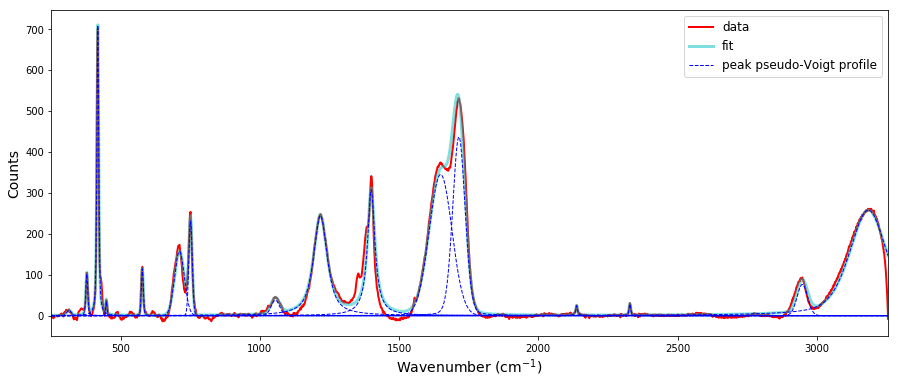

In [21]:
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

### spectrafit.export_fit_data(x_data, y_data, out):
    This function returns fit information for an input lmfit model set as well as calculates
    the area under each individual pseudo-Voigt profile. It specifically formats these values
    as a list of lists that later functions will use to save the values into a .hdf5 file.
 
    Args:
        out (lmfit.model.ModelResult): An lmfit model class that contains all of the
                        fitted values for the input model class.
    Returns:
        fit_peak_data (list): An array containing both the peak number, as well as the
                        fraction Lorentzian character, sigma, center, amplitude, full-width,
                        half-max, and the height of the peaks. The data for peak i can be
                        accessed by the array positions shown here:
                            fit_peak_data[i][0] = p[i]_fraction
                            fit_peak_data[i][1] = p[i]_simga
                            fit_peak_data[i][2] = p[i]_center
                            fit_peak_data[i][3] = p[i]_amplitude
                            fit_peak_data[i][4] = p[i]_fwhm
                            fit_peak_data[i][5] = p[i]_height
                            fit_park_data[i][6] = p[i]_area under the curve

In [25]:
fit_results, residuals = spectrafit.export_fit_data(x_data, y_data, out)
fit_results

[[2.6663343662414185e-06,
  9.47784157647681,
  314.77,
  251.85266516909158,
  18.95568315295362,
  12.481722612766571,
  251.85253918930138],
 [0.5068131437798339,
  4.012901866707115,
  378.71,
  1034.0055674054267,
  8.02580373341423,
  101.25996252105841,
  1028.5887071980997],
 [0.6367815603244544,
  3.8475935994386825,
  418.14,
  7306.162435095841,
  7.695187198877365,
  708.8643993377336,
  7270.348695381032],
 [2.5523040143748954e-05,
  2.6996218653839077,
  448.67,
  193.73417517489642,
  5.399243730767815,
  33.708352142555285,
  193.7406253262912],
 [0.18866606541747744,
  4.210622397807715,
  578.11,
  1090.4680133146153,
  8.42124479561543,
  114.24989721919599,
  1089.487881792328],
 [2.4424906541753444e-15,
  20.497872123028607,
  711.51,
  6837.146956393162,
  40.995744246057214,
  156.67652457367774,
  6837.146565168508],
 [6.887108716102652e-07,
  7.194622077882865,
  751.21,
  3533.4394037901616,
  14.38924415576573,
  230.689251297801,
  3533.443153749849],
 [0.0,

###  spectrafit.fit_data(x_data, y_data):

This wrapper function and uses the **spectrafit.export_fit_data** builder functions takes as an input only the x_data and y_data for a Raman spectra and returns a list of the fit result values in the form of the output of the spectrafit.export_fit_data function.
    
    Args:
        x_data (list like): The x-values of the spectra from which peaks will be detected.
        y_data (list like): The y-values of the spectra from which peaks will be detected.
    Returns:
        fit_result (list): An array containing both the peak number, as well as the
                        fraction Lorentzian character, sigma, center, amplitude, full-width,
                        half-max, and the height of the peaks. The data for peak i can be
                        accessed by the array positions shown here:
                            fit_result[i][0] = p[i]_fraction
                            fit_result[i][1] = p[i]_simga
                            fit_result[i][2] = p[i]_center
                            fit_result[i][3] = p[i]_amplitude
                            fit_result[i][4] = p[i]_fwhm
                            fit_result[i][5] = p[i]_height
                            fit_result[i][6] = p[i]_area under the curve


### spectrafit.build_custom_model(x_data, y_data, peaks, peaks_add, plot_fits):

This function is primarily utilized via the **dataprep.adjust_peaks function**. It allows a custom lmfit.model.CompositeModel to be generated using a list of accepted peak values and a list of new peak values to be added based on user experience and expertise. User input peaks are slightly less constrained than those automatically detected using local maximia and therefore their center (wavenumber) value may shift slighty to optimize the fit.

    Args:
        x_data (list like): The x-values of the spectra from which peaks will be detected.
        y_data (list like): The y-values of the spectra from which peaks will be detected.
        peaks (list): A list containing tuples of the x_data (wavenumber) and y_data (counts)
                      values of the peaks.
        peaks_add (list): A list of tuples containing user specified peak locations to be added to
                          the fit as well as interpolated values to provide an initial height guess.
        plot_fits (boolean): A simple True/False boolean input that determins if the plot_fit
                      function should be used to display the resulting fit for visual inspection.
    Returns:
        fit_result (list): An array containing both the peak number, as well as the
                        fraction Lorentzian character, sigma, center, amplitude, full-width,
                        half-max, and the height of the peaks. The data for peak i can be
                        accessed by the array positions shown here:
                            fit_result[i][0] = p[i]_fraction
                            fit_result[i][1] = p[i]_simga
                            fit_result[i][2] = p[i]_center
                            fit_result[i][3] = p[i]_amplitude
                            fit_result[i][4] = p[i]_fwhm
                            fit_result[i][5] = p[i]_height
                            fit_result[i][6] = p[i]_area under the curve


### spectrafit.apply_old_model(x_data, y_data, peaks, plot_fits):
    
This function is used within the **superimpose_set** function to apply and existing fit to the next spectra in a decomposition series. It helps to improve consistency of fits that do not vary signficantly between residence times. This avoids bad fits where the peak shape can vary significantly between residence times.

    Args:
        x_data (list like): The x-values of the spectra for which the model will be fit.
        y_data (list like): The y-values of the spectra for which the model will be fit.
        peaks (list): A list containing tuples of pseudo-Voigt decriptors for each peak.
        plot_fits (boolean): A simple True/False boolean input that determins if the plot_fit
                      function should be used to display the resulting fit for visual inspection.
    Returns:
        fit_result (list): An array containing both the peak number, as well as the
                        fraction Lorentzian character, sigma, center, amplitude, full-width,
                        half-max, the height, and the area under the curve of the peaks. The
                        data for peak i can be accessed by the array positions shown here:
                            fit_result[i][0] = p[i]_fraction
                            fit_result[i][1] = p[i]_simga
                            fit_result[i][2] = p[i]_center
                            fit_result[i][3] = p[i]_amplitude
                            fit_result[i][4] = p[i]_fwhm
                            fit_result[i][5] = p[i]_height
                            fit_result[i][6] = p[i]_area under the curve
        residuals ():


### spectrafit.superimpose_next(hdf5_filename, existing_key, new_key, plot_fits):

This function is used within the **superimpose_set** function and extracts the relevant data from the hdf5 file, feeds it into the **apply_old_model** function, and saves the new fit result over the existing result.

    Args:
        hdf5_filename (str): The name and location of the relevant hdf5 datafile.
        existing_key (str): The key within `hdf5_filename` that corresponds to the
                            existing fit that will be superimposed on the next spectra.
        new-key (str): The key within `hdf5_filename` that corresponds to the spectra
                       that the existing_key fit will be superimposed upon.
        plot_fits (boolean): A simple True/False boolean input that determins if the plot_fit
                      function should be used to display the resulting fit for visual inspection.
    Returns:
        None

### spectrafit.superimpose_set(hdf5_filename, target_key, plot_fits=True):

A wrapper function that can be used to apply a user adjusted fit from the shortest residence time spectra to all susequent residence times in a set of spectra decomposed at the same temperature.

    Args:
        hdf5_filename (str): The name and location of the relevant hdf5 datafile.
        target_key (str): The key within 'hdf5_filename' that corresponds to the
                            existing fit that will be superimposed on all susequent spectra.
        plot_fits (boolean): A simple True/False boolean input that determins if the plot_fit
                      function should be used to display the resulting fit for visual inspection.
    Returns:
        None